# Differences Between Bias Instability Models

**Goal:  Determine which bias instability model best simulates bias instability.** 

We are interested in comparing three different models:
- First Order Markov 
- MATLAB Model (or Filter Model)
- Aceinna Model

## First Order Markov
We first saw the first order markov model in K. Jerath's Presentation *Noise Modeling of Sensors:  The Allan Variance Method*.

Each point $b$ in the simulated time series is calculated from an initial conditon $b_{0}$ according to $\dot{b} = -\frac{b}{T_{c}}+\eta_{b}$. 

The appeal of the first order markov model is that **correlation time $T_{c}$** is explicitly defined in the model.

## MATALB Model (or Filter Model)
MATLAB implements bias instability through its `imuSensor` object. This model filters a white noise time series into 1/f noise - also known as bias instability.

MATLAB is closed source, so it's not possible (right now) to inspect the code directly. However, K. Jerath implemented the same method in **[1](https://www.mathworks.com/matlabcentral/fileexchange/64590-allan-variance-analysis-of-simulated-sensor-noise)**.

The drawback of this model is that correlation time is not explicitly used. However, the model consistently yields a PSD with the correct characteristics and can be used to accurately determine the bias instability coefficient from an Allan deviation plot. 

## Aceinna Model
This model is an implementation of First Order Gauss-Markov model (discussed above). The exact equation used is derived in Section 3.2 of [Quinchia, et. al](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3812568/).

This model computes a discrete bias instability time series according to:

$x_{k} = (1-\beta\Delta t)x_{k-1} + \sigma_{GM}\sqrt{(1-e^{\frac{-2\Delta t}{T_{c}}})}w_{k}$

We can rewrite this equation as:

$x_{k}=(1-\frac{1}{T_{c}}\frac{1}{f_{s}})x_{k-1} + B \sqrt{(1-e^{\frac{-2}{f_{s}T_{c}}})}w_{k}$

Then, it is natural to provide a bias coefficient $B$, a correlation time $T_{c}$, and sampling frequency $f_{s}$ to compute our bias instability time series. 

Note that $w{k}$ are samples from a standard normal distribution.


---

# References

**[1]**  Kshitij Jerath (2021). Allan variance analysis of simulated sensor noise (https://www.mathworks.com/matlabcentral/fileexchange/64590-allan-variance-analysis-of-simulated-sensor-noise), MATLAB Central File Exchange. Retrieved July 27, 2021. 

# Imports

In [1]:
# Clone Allan Online repo to notebook directory
!git clone https://github.com/nurriol2/allan-online.git

# Clone GNSS INS Simulation repo to notebook directory 
!git clone https://github.com/Aceinna/gnss-ins-sim.git

from IPython.display import clear_output
clear_output()

In [2]:
import sys
import os

# Make Allan Online files `import`-able
allan_online_dir = "./allan-online"
sys.path.append(os.path.abspath(allan_online_dir))

# Make Aceinna GNSS INS Simulation files `import`-able
aceinna_pathgen_dir = "./gnss-ins-sim/" # Only need `gnss-ins-sim/gnss_ins_sim/pathgen/pathgen.py`
sys.path.append(os.path.abspath(aceinna_pathgen_dir))


# Standard imports
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import welch



# Function for calculating the overlapping Allan deviation of a time series
from allan_variance import overlapping_allan_deviation
# First Order Markov model for bias instability
from noise_synthesis import make_bias_instability_series as first_order_markov
# MATLAB Model - Shaping white noise with a filter
from noise_synthesis import simulate_flicker_noise as matlab_model
# Acienna bias instability model
from gnss_ins_sim.pathgen.pathgen import bias_drift

## Convenience Alias
The Acienna model is explicitly implemented for all 3 axes. Conversely, the other models are only single axis.

Below we define an alias for `bias_drift` from Aceinna called `aceinna_model`that runs the same code as `bias_drift` but returns sensor bias drift for only a single axis.

In [3]:
def aceinna_model(corr_time, drift, n, fs):
    """Reduce the dimension of the Aceinna model by selecting only 1
    of the 3 returned sensor bias drift series. Alias of `bias_drift`.

    Bias drift (instability) model for accelerometers or gyroscope.
    If correlation time is valid (positive and finite), a first-order Gauss-Markov model is used.
    Otherwise, a simple normal distribution model is used.
    Args:
        corr_time: 3x1 correlation time, sec.
        drift: 3x1 bias drift std, rad/s.
        n: total data count
        fs: sample frequency, Hz.
    Returns
        sensor_bias_drift: drift of sensor bias
    """
    return bias_drift([corr_time for i in range(3)], [drift for i in range(3)], n, fs)[:, 0]

In [4]:
# Constant paramaters shared between each of the models
SAMPLING_RATE = 100 # Hertz
SIM_TIME = 10000 # Seconds
NUM_POINTS = SAMPLING_RATE*SIM_TIME
CORRELATION_TIME = 1000 # T_{c}
BI_COEFF = 0.01
TRUNCATION  = 5000 # Number of coefficients for the IIR Filter

In [5]:
class BiasInstabilityModel:

    def __init__(self, name, simulator, *args):
        self.name = name
        self.simulator = simulator
        self.noise_amplitudes = self._set_noise_amplitudes(*args)
        return

    def _set_noise_amplitudes(self, params):
        """Compute the noise amplitudes for each time step given a list of
        input parameters for the simulator function
        """
        return self.simulator(*params)

    def plot_time_series(self, sim_time, sampling_rate):
        time_stamps = np.arange(0, sim_time, 1/sampling_rate)
        plt.plot(time_stamps, self.noise_amplitudes)

        plt.xlabel("Time (sec)")
        plt.ylabel("Noise Amplitude")
        plt.title(f"{self.name} Noise Amplitude Time Series")

        plt.grid(b=True)
        
        plt.show()
        return 

    def compute_psd(self, fs):
        """Use Welch's method to compute the power spectral density of the model
        """
        freq, pxx = welch(self.noise_amplitudes, fs)
        return (freq, pxx)

    def plot_psd(self, fs):
        """Plot the power spectral density of the current model
        """
        freq, pxx = self.compute_psd(fs)
        plt.loglog(freq, pxx)
        
        plt.xlabel("Frequency (HZ)")
        plt.ylabel("Power Density")
        plt.title(f"Power Spectral Density - {self.name}")

        plt.grid(b=True)

        plt.show()
        return 

    def compute_oadev(self, fs):
        """Calculate the overlapping Allan deviation of the current model
        """
        tau, allan = overlapping_allan_deviation(self.noise_amplitudes, fs)
        return (tau, allan)

    def plot_oadev(self, fs):
        """Plot the overlapping Allan deviation of the current model
        """
        tau, allan = self.compute_oadev(fs)

        plt.loglog(tau, allan, label=self.name)

        plt.xlabel("Averaging Time \u03C4 (sec)")
        plt.ylabel("Computed Allan Deviation \u03C3(\u03C4)")
        plt.title(f"Allan Deviation - {self.name}")

        plt.grid(b=True)
        
        plt.show()
        return 
 

In [6]:
# Different model simulators require different input parameters
markov_params = [BI_COEFF, CORRELATION_TIME, SAMPLING_RATE, SIM_TIME]
matlab_params = [BI_COEFF, SAMPLING_RATE, SIM_TIME, TRUNCATION]
aceinna_params = [CORRELATION_TIME, BI_COEFF, NUM_POINTS, SAMPLING_RATE]

In [7]:
# Create multipe Bias Instability Models using different simulator functions
markov = BiasInstabilityModel("First Order Markov", first_order_markov, markov_params)
matlab = BiasInstabilityModel("MATLAB/Filter Model", matlab_model, matlab_params)
aceinna = BiasInstabilityModel("Aceinna GM", aceinna_model, aceinna_params)

In [8]:
models = [markov, matlab, aceinna]

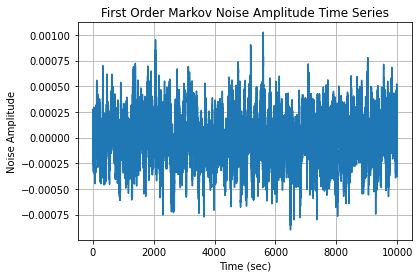

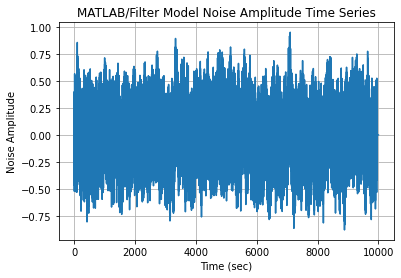

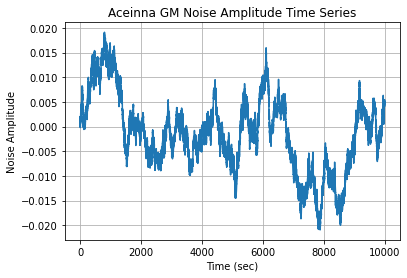

In [9]:
# Plot each time series individually
for model in models:
    model.plot_time_series(SIM_TIME, SAMPLING_RATE)
    plt.close()

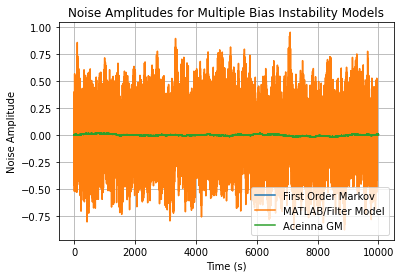

In [10]:
time_stamps = np.arange(0, SIM_TIME, 1/SAMPLING_RATE)

for model in models:
    # Combine each time series into a single plot    
    plt.plot(time_stamps, model.noise_amplitudes, label=model.name)

plt.legend(loc="lower right")

plt.xlabel("Time (s)")
plt.ylabel("Noise Amplitude")
plt.title("Noise Amplitudes for Multiple Bias Instability Models")
plt.grid(b=True)